# Notebook application example of CounterFactual Augmentation 

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors

class CFA:
    def __init__(self, fd, tol):
        """
        Initialize the CFA algorithm with feature differences (fd) and tolerance (tol) thresholds.

        :param fd: Maximum number of features that can differ to consider data points as paired.
        :param tol: Specified tolerance percentage for feature values.
        """
        self.fd = fd
        self.tol = tol

    def calculate_tolerance(self, X):
        """
        Calculate the tolerance for each feature.

        :param X: Feature dataset.
        :return: Tolerance values for each feature.
        """
        std_dev = np.std(X, axis=0)
        return self.tol * std_dev

    def separate_classes(self, X, y):
        """
        Separate the dataset into majority and minority classes.

        :param X: Feature dataset.
        :param y: Class labels.
        :return: Majority and minority class data.
        """
       
        unique_classes, counts = np.unique(y, return_counts=True)
        majority_class_index = np.argmax(counts)
        majority_class = unique_classes[majority_class_index]
        majority_data = X[y == majority_class]
        minority_data = X[y != majority_class]
        
        return majority_data, minority_data

    def compute_cf_set(self, X, neighbors_model):
        """
        Compute the CF-Set for each instance in X.

        :param X: Dataset to compute CF-Set.
        :param neighbors_model: Nearest neighbors model for finding nearest neighbor.
        :return: Array of indices of nearest neighbors.
        """
        distances, indices = neighbors_model.kneighbors(X)
        
        return indices[:, 0]

    def check_feature_differences(self, x, y, tolerance):
        """
        Check the number of feature differences between two instances within the tolerance.

        :param x: First instance.
        :param y: Second instance.
        :param tolerance: Tolerance values for each feature.
        :return: Number of features that differ.
        """
        return np.sum(np.abs(x - y) > tolerance)

    def generate_synthetic_instance(self, x, xp, p):
        """
        Generate a synthetic counterfactual instance.

        :param x: Native instance.
        :param p: Counterfactual instance from CF-Set.
        :return: Synthetic instance.
        """
        return x +(xp - p)

    def run_cfa(self, X, y):
        """
        Run the CFA algorithm on a given dataset.

        :param X: Feature dataset.
        :param y: Class labels.
        :return: Set of synthetic counterfactual instances.
        """
        tolerance = self.calculate_tolerance(X)
        majority_data, minority_data = self.separate_classes(X, y)

        nn_model = NearestNeighbors(n_neighbors=1).fit(majority_data)
        cf_set_indices = self.compute_cf_set(minority_data, nn_model)
        
        # Pair Majo - Mino
        paired_instances_indices = []
        paired_instances = []
        
        for i, idx in enumerate(cf_set_indices):
            #print(majority_data[idx],'is located at idx', np.where((X == majority_data[idx]).all(axis=1))[0][0],'in X')
            #print(np.where(X == majority_data[idx])[0][0], np.where(X == majority_data[i])[0][0])
            paired_instances_indices.append((np.where((X == majority_data[idx]).all(axis=1))[0][0], np.where((X == minority_data[i]).all(axis=1))[0][0]))
            paired_instances.append((majority_data[idx], minority_data[i])) # (majority_data instance, minority_data instance)
            
        print('X',X)
        print('pi',paired_instances_indices)
        
       
        # Pair Non paired Majo - Paired Majo
        npmaj_pmaj = []
        npmaj_pmaj_indices = []
        
        #print('paired_instances from majo', np.array(paired_instances)[:,0])
        #print('majority_data', majority_data)
        for i,np_maj in enumerate(majority_data):
            #print('np_maj: ', np_maj, 'paired_instances: ', np.array(paired_instances)[:,0])
            
            
           
            if not np.any(np.all(np.array(paired_instances)[:,0] == np.array(np_maj), axis=1)):
                # print('np_maj', np_maj, 'not in paired_instances', np.array(paired_instances)[:,0])
                
                # Check the data in majority data that is paired the closest to np maj
                nn_model = NearestNeighbors(n_neighbors=1).fit(np.array(paired_instances)[:,0])
                _, indices = nn_model.kneighbors(np.array([np_maj]))
                # print('indices: ', indices)
                # print(i,majority_data[i])
                print(np.where((X==np.array(majority_data)[i]).all(axis=1))[0][0])
                npmaj_pmaj_indices.append((np.where((X==np.array(majority_data)[i]).all(axis=1))[0][0], np.where((X==np.array(paired_instances)[indices[0][0]][0]).all(axis=1))[0][0]))
                npmaj_pmaj.append((majority_data[i], paired_instances[indices[0][0]][0]))
                
        print('npmaj_pmaj_indices: ', npmaj_pmaj_indices)
        print('npmaj_pmaj: ', npmaj_pmaj)
                
                
        
                
        
        # Transfer Non paire Majo - Paired Majo - Mino   
        synthetic_instances = []  
        for id, p in zip(npmaj_pmaj_indices, npmaj_pmaj):
            print("id: ", id)
            print("p: ", p)
            
            
            print('pi',paired_instances)
            print('pi',np.array(paired_instances)[:,0])
            print('p1',p[1])
            print(np.where(np.all(np.array([elem[0] for elem in paired_instances]) == p[1], axis=1))[0])
            
            
            
        
            if self.check_feature_differences(p[1],np.array(paired_instances)[np.where((np.array(paired_instances)[:,0] == p[1]).all(axis=1))[0]][0][1], tolerance) <= self.fd:
                
                print('PHASE 2----------------------')
                print(p[1], np.array(paired_instances)[np.where((np.array(paired_instances)[:,0] == p[1]).all(axis=1))[0]][0][1])
                synthetic_instances.append(self.generate_synthetic_instance(p[0], np.array(paired_instances)[np.where((np.array(paired_instances)[:,0] == p[1]).all(axis=1))[0]][0][1], p[1]))
             
        return np.array(synthetic_instances)



In [226]:
p = np.array([[0,0,0],[0,0,0]])
print('mino',np.where((np.array(paired_instances)[:,0] == p[1]).all(axis=1))[0])
pi = np.array([0,0,0])

np.where((p == pi).all(axis=1))[0]

array([0, 1])

In [163]:
t = np.array([[1, 2], [4, 5], [7, 8]])

t[0] - t[1] + t[2]


array([4, 5])

## Data Loading

For the sake of an example we consider a two-class problem with 3 features data. Each feature following a Gaussian Distribution with different parameters $(\mu, \sigma^2)$.

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Number of samples per class
n_1 = 150
n_2 = 35

# Class 1 parameters
mean_class1 = [20, 10, 15]
std_class1 = [1, 2, 3]

# Class 2 parameters
mean_class2 = [10, 15, 20]
std_class2 = [1.5, 2.5, 3.5]

# Generate data 
data_class1 = [[0,0,0],[0,0,3],[0,0,5]]
data_class2 = [[1,2,0],[1,3,0]]

# Create DataFrame and add class labels
df_class1 = pd.DataFrame(data_class1, columns=['Feature1', 'Feature2','Feature3'])
df_class1['Class'] = 1
df_class2 = pd.DataFrame(data_class2, columns=['Feature1', 'Feature2','Feature3'])
df_class2['Class'] = 2
df = pd.concat([df_class1, df_class2], ignore_index=True)

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)


df.head()




,Feature1,Feature2,Feature3,Class
0,0,0,3,1
1,0,0,0,1
2,1,2,0,2
3,0,0,5,1
4,1,3,0,2


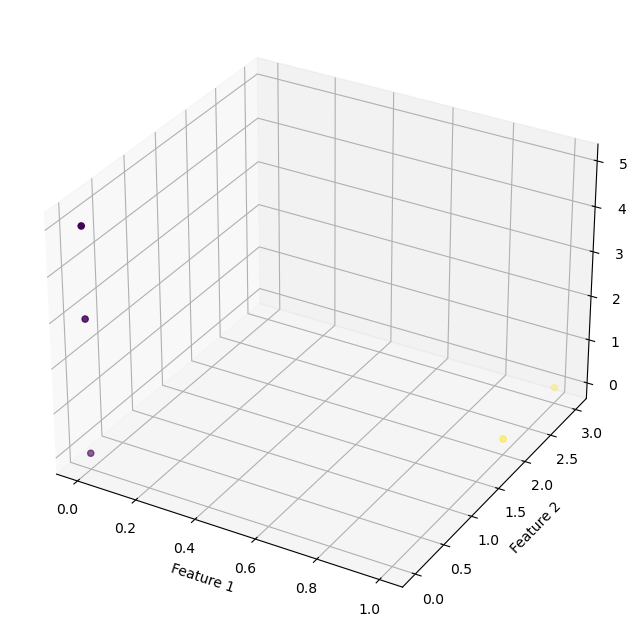

In [180]:
# Plot the data 3D
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Feature1'], df['Feature2'],df['Feature3'], c=df['Class'])
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

plt.show()

In [230]:
# Creating CFA synthetic counterfactuals data


cfa = CFA( fd=3, tol = 0.1)

X = df[['Feature1', 'Feature2', 'Feature3']].values
y = df['Class'].values
synthetic_counterfactuals = cfa.run_cfa(X, y)
# Add the synthetic counterfactuals to the original data, the class label is 2 (minority classes), add column that indicates the synthetic counterfactuals or not

df_cfa = pd.DataFrame(synthetic_counterfactuals, columns=['Feature1', 'Feature2', 'Feature3'])
df_cfa['Class'] = 2
df_cfa['Synthetic'] = 1
df_cfa = pd.concat([df, df_cfa], ignore_index=True)
df_cfa['Synthetic'] = df_cfa['Synthetic'].fillna(0)
df_cfa






X [[0 0 3]
 [0 0 0]
 [1 2 0]
 [0 0 5]
 [1 3 0]]
pi [(1, 2), (1, 4)]
0
3
npmaj_pmaj_indices:  [(0, 1), (3, 1)]
npmaj_pmaj:  [(array([0, 0, 3]), array([0, 0, 0])), (array([0, 0, 5]), array([0, 0, 0]))]
id:  (0, 1)
p:  (array([0, 0, 3]), array([0, 0, 0]))
pi [(array([0, 0, 0]), array([1, 2, 0])), (array([0, 0, 0]), array([1, 3, 0]))]
pi [[0 0 0]
 [0 0 0]]
p1 [0 0 0]
[0 1]
PHASE 2----------------------
[0 0 0] [1 2 0]
id:  (3, 1)
p:  (array([0, 0, 5]), array([0, 0, 0]))
pi [(array([0, 0, 0]), array([1, 2, 0])), (array([0, 0, 0]), array([1, 3, 0]))]
pi [[0 0 0]
 [0 0 0]]
p1 [0 0 0]
[0 1]
PHASE 2----------------------
[0 0 0] [1 2 0]


,Feature1,Feature2,Feature3,Class,Synthetic
0,0,0,3,1,0.0
1,0,0,0,1,0.0
2,1,2,0,2,0.0
3,0,0,5,1,0.0
4,1,3,0,2,0.0
5,1,2,3,2,1.0
6,1,2,5,2,1.0


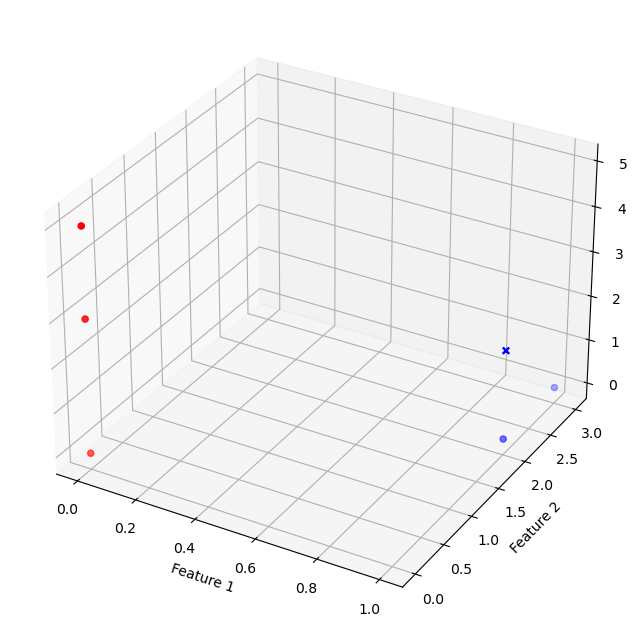

In [231]:
# Plot the data
import matplotlib
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
color = ['red', 'blue', 'green'] # color for each class, the first class is red, the second class is blue, the synthetic counterfactuals are green
ax.scatter(df_cfa[df_cfa['Synthetic'] == 0]['Feature1'], df_cfa[df_cfa['Synthetic'] == 0]['Feature2'],df_cfa[df_cfa['Synthetic'] == 0]['Feature3'], c=df_cfa[df_cfa['Synthetic'] == 0]['Class'].apply(lambda x: color[x-1]), label='Original data')
ax.scatter(df_cfa[df_cfa['Synthetic'] == 1]['Feature1'], df_cfa[df_cfa['Synthetic'] == 1]['Feature2'],df_cfa[df_cfa['Synthetic'] == 1]['Feature2'], c=df_cfa[df_cfa['Synthetic'] == 1]['Class'].apply(lambda x: color[x-1]), marker='x', label='Synthetic counterfactuals')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')

plt.show()

In [232]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Number of samples per class
n_1 = 150
n_2 = 35

# Class 1 parameters
mean_class1 = [20, 10, 15]
std_class1 = [1, 2, 3]

# Class 2 parameters
mean_class2 = [10, 15, 20]
std_class2 = [1.5, 2.5, 3.5]

# Generate data 
data_class1 = np.random.normal(loc=mean_class1, scale=std_class1, size=(n_1, 3))
data_class2 = np.random.normal(loc=mean_class2, scale=std_class2, size=(n_2, 3))

# Create DataFrame and add class labels
df_class1 = pd.DataFrame(data_class1, columns=['Feature1', 'Feature2', 'Feature3'])
df_class1['Class'] = 1
df_class2 = pd.DataFrame(data_class2, columns=['Feature1', 'Feature2', 'Feature3'])
df_class2['Class'] = 2
df = pd.concat([df_class1, df_class2], ignore_index=True)

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)


df.head()




,Feature1,Feature2,Feature3,Class
0,20.700490,12.954199,16.806636,1
1,20.439275,8.875155,12.110669,1
2,19.910857,12.072246,11.429869,1
3,12.643659,15.565790,23.440659,2
4,19.790647,10.425311,14.890558,1


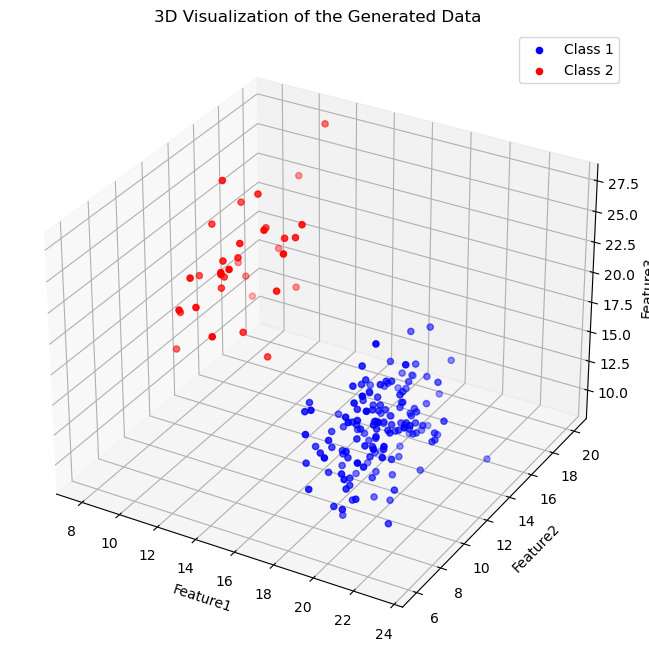

In [233]:
# 3D Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_class1['Feature1'], df_class1['Feature2'], df_class1['Feature3'], color='blue', label='Class 1')
ax.scatter(df_class2['Feature1'], df_class2['Feature2'], df_class2['Feature3'], color='red', label='Class 2')

ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')
ax.set_title('3D Visualization of the Generated Data')
ax.legend()

plt.show()

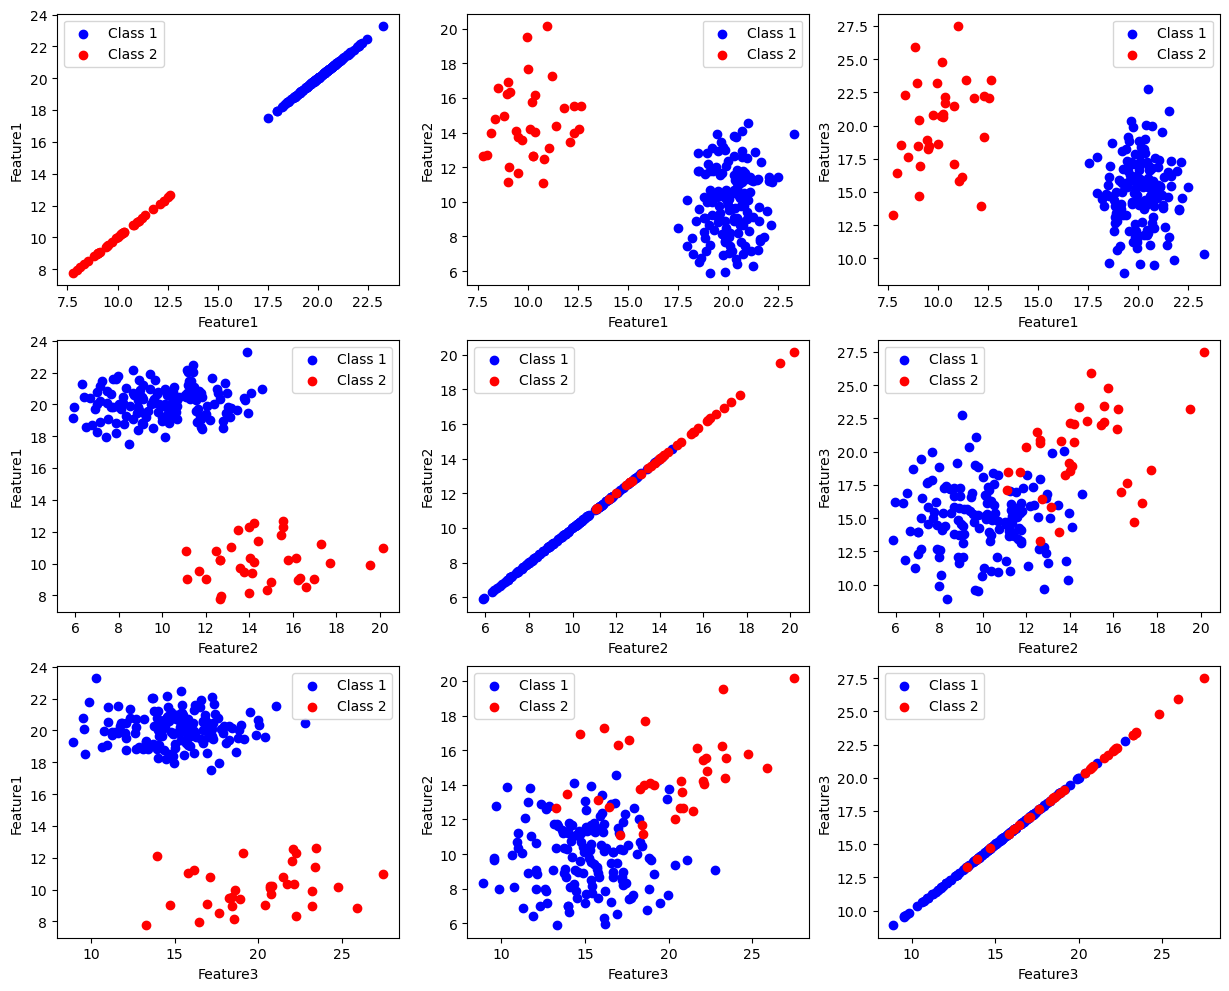

In [234]:
# Show the data of 2D plan for each possible pair of features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i in range(1, 4):
    for j in range(1, 4):
        axes[i - 1, j - 1].scatter(df_class1[f'Feature{i}'], df_class1[f'Feature{j}'], color='blue', label='Class 1')
        axes[i - 1, j - 1].scatter(df_class2[f'Feature{i}'], df_class2[f'Feature{j}'], color='red', label='Class 2')
        axes[i - 1, j - 1].set_xlabel(f'Feature{i}')
        axes[i - 1, j - 1].set_ylabel(f'Feature{j}')
        axes[i - 1, j - 1].legend()

plt.show()

## CounterFactual Augmentation


In [238]:
# Creating CFA synthetic counterfactuals data


cfa = CFA(fd=3, tol=0.1)

X = df[['Feature1', 'Feature2', 'Feature3']].values
y = df['Class'].values
synthetic_counterfactuals = cfa.run_cfa(X, y)



X [[20.70048953 12.95419873 16.80663636]
 [20.43927462  8.87515505 12.11066905]
 [19.91085701 12.07224641 11.42986871]
 [12.64365891 15.5657904  23.44065947]
 [19.79064675 10.42531149 14.89055843]
 [20.80714373 10.4996677  17.58184274]
 [10.12221275 14.20100055 20.7255588 ]
 [19.61335817  9.34331372 20.37759442]
 [20.55716806 10.36229646 10.98573946]
 [19.67898942 11.65807835 14.22634252]
 [ 9.10128227 16.32876407 16.96064301]
 [20.07916832 10.52463343 15.98358783]
 [10.00443029 17.69956126 18.58860098]
 [19.4078547  12.02231448 18.2645502 ]
 [20.19071452  7.15172368 12.70616383]
 [21.80344899  7.98393998  9.85950689]
 [20.73808418 11.76649124 13.14138269]
 [19.10121668 10.69476129 10.94405599]
 [10.79979677 12.4738244  21.49305027]
 [18.27192917  7.01547715 13.98165647]
 [20.99480538 10.11307812 15.12928967]
 [19.94863976 10.18759833 16.13693477]
 [20.85959362  7.46291934 14.54460148]
 [22.05193847 11.41006089 13.64138849]
 [20.46375805  6.41322135 11.87945124]
 [19.06020937  8.665874

In [239]:
synthetic_counterfactuals

array([[11.27852433, 16.71285259, 20.00755366],
       [10.2449948 , 11.38262642, 10.46396674],
       [10.52965598, 16.59264488, 12.84593365],
       [ 9.59636694, 12.93278286, 13.24385612],
       [14.56032681, 12.70467143, 20.55098415],
       [12.51188966, 11.754483  , 23.93690985],
       [10.36288825, 12.86976782,  9.33903715],
       [10.2977884 , 16.17847682, 15.64240746],
       [13.8323514 , 12.72963716, 18.95272924],
       [12.30638619, 14.43348376, 21.82386562],
       [ 9.9964347 ,  9.65919504, 11.05946152],
       [11.60916917, 10.49141135,  8.21280458],
       [11.35688316, 16.28688971, 14.55744763],
       [ 8.90693687, 13.20223265,  9.29735368],
       [ 8.07764935,  9.52294852, 12.33495417],
       [10.80052557, 12.62054949, 13.48258736],
       [13.70182284, 12.39260206, 19.10607618],
       [10.66531381,  9.97039071, 12.89789917],
       [12.62997328, 15.16871475, 16.84230579],
       [10.26947824,  8.92069272, 10.23274894],
       [ 8.86592955, 11.17334566, 12.195

In [240]:
# Add the synthetic counterfactuals to the original data, the class label is 2 (minority classes), add column that indicates the synthetic counterfactuals or not

df_cfa = pd.DataFrame(synthetic_counterfactuals, columns=['Feature1', 'Feature2', 'Feature3'])
df_cfa['Class'] = 2
df_cfa['Synthetic'] = 1
df_cfa = pd.concat([df, df_cfa], ignore_index=True)
df_cfa['Synthetic'] = df_cfa['Synthetic'].fillna(0)
df_cfa





,Feature1,Feature2,Feature3,Class,Synthetic
0,20.700490,12.954199,16.806636,1,0.0
1,20.439275,8.875155,12.110669,1,0.0
2,19.910857,12.072246,11.429869,1,0.0
3,12.643659,15.565790,23.440659,2,0.0
4,19.790647,10.425311,14.890558,1,0.0
...,...,...,...,...,...
324,9.682802,11.024212,13.708454,2,1.0
325,9.326074,13.136268,10.418435,2,1.0
326,11.311494,15.651265,15.895436,2,1.0
327,13.940129,11.659136,24.263909,2,1.0


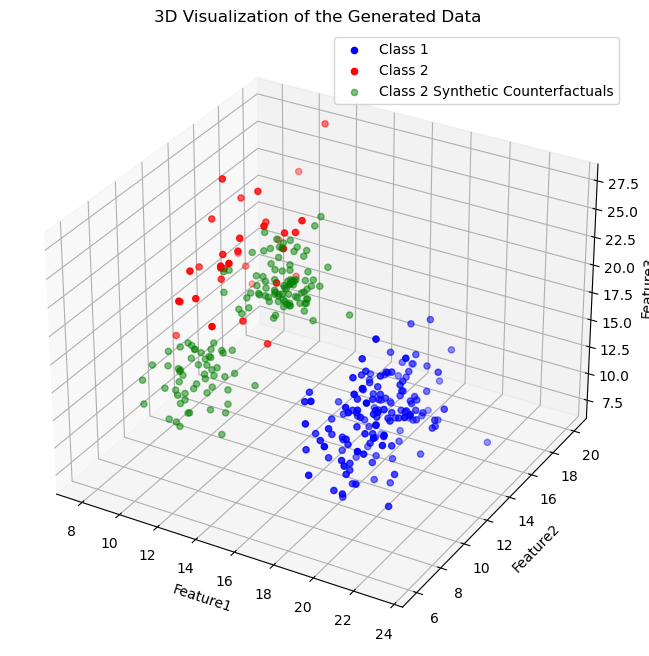

In [241]:
# 3D Plotting (with synthetic counterfactuals alpha = 0.5)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

#plot points from class 1
ax.scatter(df_cfa[df_cfa['Class'] == 1]['Feature1'], df_cfa[df_cfa['Class'] == 1]['Feature2'], df_cfa[df_cfa['Class'] == 1]['Feature3'], color='blue', label='Class 1')
#plot point from class 2 not synthetic counterfactuals
ax.scatter(df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 0)]['Feature1'], df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 0)]['Feature2'], df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 0)]['Feature3'], color='red', label='Class 2')

#plot point from class 2 synthetic counterfactuals
ax.scatter(df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 1)]['Feature1'], df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 1)]['Feature2'], df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 1)]['Feature3'], color='green', alpha=0.5, label='Class 2 Synthetic Counterfactuals')



ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')
ax.set_title('3D Visualization of the Generated Data')
ax.legend()

plt.show()

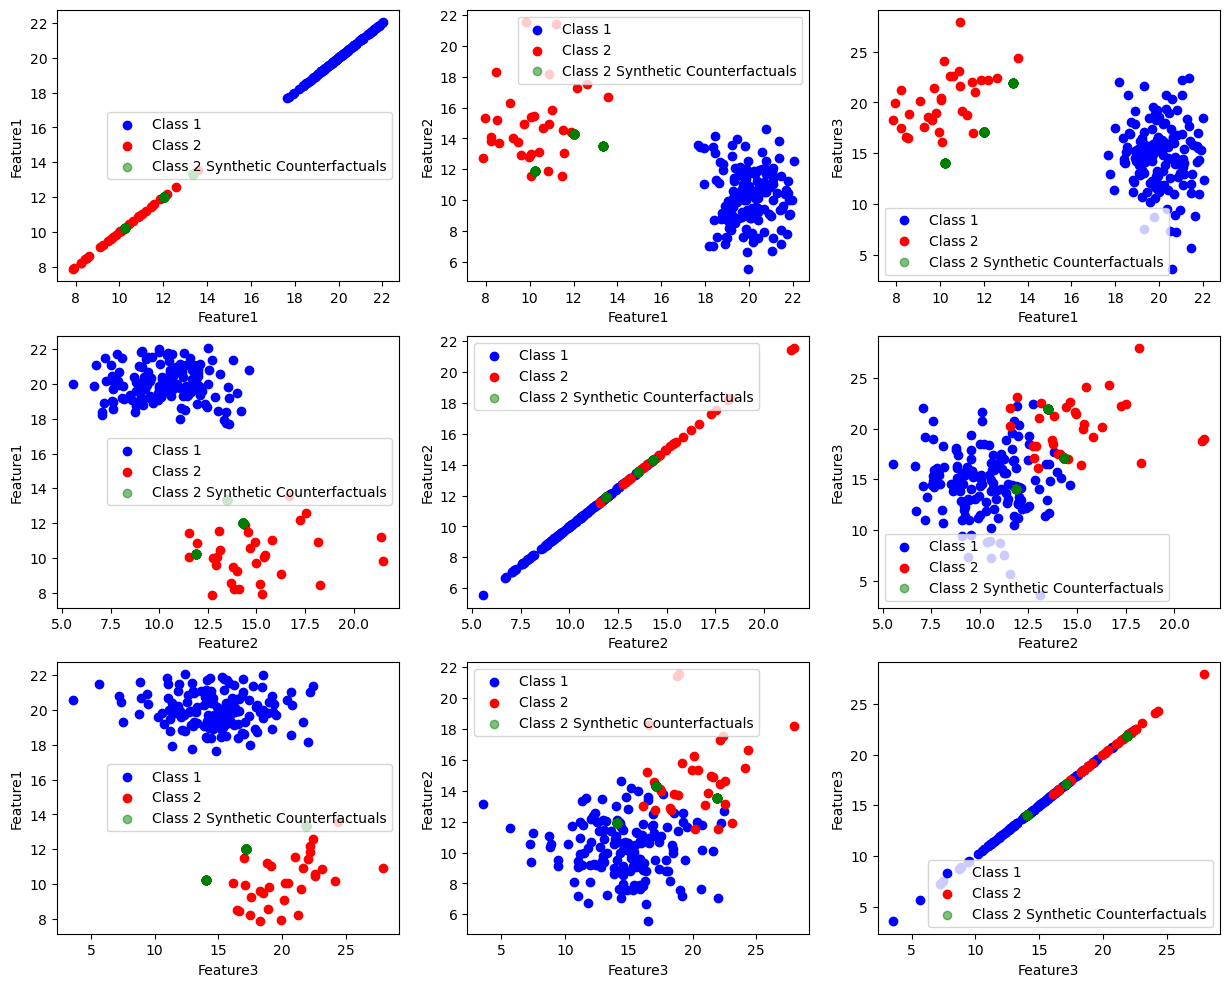

In [16]:
# Show the data of 2D plan for each possible pair of features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i in range(1, 4):
    for j in range(1, 4):
        axes[i - 1, j - 1].scatter(df_cfa[df_cfa['Class'] == 1][f'Feature{i}'], df_cfa[df_cfa['Class'] == 1][f'Feature{j}'], color='blue', label='Class 1')
        axes[i - 1, j - 1].scatter(df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 0)][f'Feature{i}'], df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 0)][f'Feature{j}'], color='red', label='Class 2')
        axes[i - 1, j - 1].scatter(df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 1)][f'Feature{i}'], df_cfa[(df_cfa['Class'] == 2) & (df_cfa['Synthetic'] == 1)][f'Feature{j}'], color='green', alpha=0.5, label='Class 2 Synthetic Counterfactuals')
        axes[i - 1, j - 1].set_xlabel(f'Feature{i}')
        axes[i - 1, j - 1].set_ylabel(f'Feature{j}')
        axes[i - 1, j - 1].legend()

plt.show()